# Overview

In this project, I will use an Alternating Least Squares (ALS) algorithm with Spark APIs to predict the ratings for the movies in [MovieLens Datasets](https://grouplens.org/datasets/movielens/latest/)

## [Recommender system](https://en.wikipedia.org/wiki/Recommender_system)
A recommendation system is basically an information filtering system that seeks to predict the "rating" or "preference" a user would give to an item. It is widely used in different internet / online business such as Amazon, Netflix, Spotify, or social media like Facebook and Youtube. By using recommender systems, those companies are able to provide better or more suited products/services/contents that are personalized to a user based on his/her historical consumer behaviors

Recommender systems typically produce a list of recommendations through collaborative filtering or through content-based filtering

This project will focus on collaborative filtering and use Alternating Least Squares (ALS) algorithm to make movie predictions


## [Alternating Least Squares](https://endymecy.gitbooks.io/spark-ml-source-analysis/content/%E6%8E%A8%E8%8D%90/papers/Large-scale%20Parallel%20Collaborative%20Filtering%20the%20Netflix%20Prize.pdf)
ALS is one of the low rank matrix approximation algorithms for collaborative filtering. ALS decomposes user-item matrix into two low rank matrixes: user matrix and item matrix. In collaborative filtering, users and products are described by a small set of latent factors that can be used to predict missing entries. And ALS algorithm learns these latent factors by matrix factorization


## Data Sets
I use [MovieLens Datasets](https://grouplens.org/datasets/movielens/latest/).
This dataset (ml-latest.zip) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 27753444 ratings and 1108997 tag applications across 58098 movies. These data were created by 283228 users between January 09, 1995 and September 26, 2018. This dataset was generated on September 26, 2018.

Users were selected at random for inclusion. All selected users had rated at least 1 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in the files `genome-scores.csv`, `genome-tags.csv`, `links.csv`, `movies.csv`, `ratings.csv` and `tags.csv`.

## Project Content
1. Load Data
2. Spark SQL and OLAP
3. Spark ALS based approach for training model
4. ALS Model Selection and Evaluation
5. Model testing
6. Make movie recommendation to myself

In [1]:
!apt-get install -y openjdk-8-jdk-headless
!pip install pyspark

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openjdk-8-jdk-headless is already the newest version (8u222-b10-1ubuntu1~18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
     |████████████████████████████████| 215.7MB 69kB/s 
     |████████████████████████████████| 204kB 42.7MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.4-py2.py3-none-any.whl size=216130387 sha256=6ee07328858ad9615931bad167e90a2891faf8443e89f2a0dae8665b0074ba47
  Stored in directory: /root/.cache/pip/wheels/ab/09/4d/0d184230058e654eb1b04467dbc1292f00eaa186544604b471
Successfully built pyspark


In [0]:
import os
import time

# spark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.mllib.recommendation import ALS

# data science imports
import math
import numpy as np
import pandas as pd

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
!git clone https://github.com/subha12k/data.git

Cloning into 'data'...
remote: Enumerating objects: 7, done.
remote: Total 7 (delta 0), reused 0 (delta 0), pack-reused 7
Unpacking objects: 100% (7/7), done.


In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode
openjdk version "1.8.0_222"
OpenJDK Runtime Environment (build 1.8.0_222-8u222-b10-1ubuntu1~18.04.1-b10)
OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)


In [5]:
import sys
import pyspark
print("Python version : ", sys.version)
print("PySpark version : ", pyspark.__version__)

Python version :  3.6.8 (default, Oct  7 2019, 12:59:55) 
[GCC 8.3.0]
PySpark version :  2.4.4


In [0]:
# spark config
spark = SparkSession \
    .builder \
    .appName("movie recommendation") \
    .config("spark.driver.maxResultSize", "96g") \
    .config("spark.driver.memory", "96g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.master", "local[12]") \
    .getOrCreate()
# get spark context
sc = spark.sparkContext

In [0]:
# path config
data_path = os.path.join('/content', 'data')

## Load Data

In [0]:
movies = spark.read.load(os.path.join(data_path, 'movies.csv'), format='csv', header=True, inferSchema=True)
ratings = spark.read.load(os.path.join(data_path, 'ratings.csv'), format='csv', header=True, inferSchema=True)
links = spark.read.load(os.path.join(data_path, 'links.csv'), format='csv', header=True, inferSchema=True)
tags = spark.read.load(os.path.join(data_path, 'tags.csv'), format='csv', header=True, inferSchema=True)

### basic inspection

In [9]:
movies.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [10]:
ratings.show(3)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
+------+-------+------+---------+
only showing top 3 rows



In [11]:
links.show(3)

+-------+------+------+
|movieId|imdbId|tmdbId|
+-------+------+------+
|      1|114709|   862|
|      2|113497|  8844|
|      3|113228| 15602|
+-------+------+------+
only showing top 3 rows



In [12]:
tags.show(10)

+------+-------+-----------------+----------+
|userId|movieId|              tag| timestamp|
+------+-------+-----------------+----------+
|     2|  60756|            funny|1445714994|
|     2|  60756|  Highly quotable|1445714996|
|     2|  60756|     will ferrell|1445714992|
|     2|  89774|     Boxing story|1445715207|
|     2|  89774|              MMA|1445715200|
|     2|  89774|        Tom Hardy|1445715205|
|     2| 106782|            drugs|1445715054|
|     2| 106782|Leonardo DiCaprio|1445715051|
|     2| 106782|  Martin Scorsese|1445715056|
|     7|  48516|     way too long|1169687325|
+------+-------+-----------------+----------+
only showing top 10 rows



## Spark SQL and OLAP

Below are the questions I'd like to ask:
1. What are the ratings?
2. What is minimum number of ratings per user and minimum number of ratings per movie?
3. How many movies are rated by only one user?
4. What is the total number of users in the data sets?
5. What is the total number of movies in the data sets?
6. How many movies are rated by users? List movies not rated yet?
7. List all movie genres
8. Find out the number of movies for each category
9. Calculate the total rating count for every movie
10. Get a count plot for each rating

What are the ratings?

In [13]:
print('Distinct values of ratings:')
print(sorted(ratings.select('rating').distinct().rdd.map(lambda r: r[0]).collect()))

Distinct values of ratings:
[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


What is minimum number of ratings per user and minimum number of ratings per movie?

In [0]:
tmp1 = ratings.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratings.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

IllegalArgumentException: ignored

How many movies are rated by only one user?

In [0]:
tmp1 = sum(ratings.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = ratings.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

IllegalArgumentException: ignored

What is the total number of users in the data sets?

In [0]:
tmp = ratings.select('userID').distinct().count()
print('We have a total of {} distinct users in the data sets'.format(tmp))

We have a total of 610 distinct users in the data sets


What is the total number of movies in the data sets?

In [0]:
tmp = movies.select('movieID').distinct().count()
print('We have a total of {} distinct movies in the data sets'.format(tmp))

We have a total of 9742 distinct movies in the data sets


How many movies are rated by users? List movies not rated yet?

In [0]:
tmp1 = movies.select('movieID').distinct().count()
tmp2 = ratings.select('movieID').distinct().count()
print('We have a total of {} distinct movies that are rated by users in ratings table'.format(tmp2))
print('We have {} movies that are not rated yet'.format(tmp1-tmp2))

We have a total of 9724 distinct movies that are rated by users in ratings table
We have 18 movies that are not rated yet


In [0]:
# create a temp SQL table view for easier query
movies.createOrReplaceTempView("movies")
ratings.createOrReplaceTempView("ratings")
print('List movies that are not rated yet: ')
# SQL query (NOTE: WHERE ... NOT IN ... == ... LEFT JOIN ... WHERE ... IS NULL)
# Approach 1
spark.sql(
    "SELECT movieId, title "
    "FROM movies "
    "WHERE movieId NOT IN (SELECT distinct(movieId) FROM ratings)"
).show(10)
# Approach 2
# spark.sql(
#     "SELECT m.movieId, m.title "
#     "FROM movies m LEFT JOIN ratings r ON m.movieId=r.movieId "
#     "WHERE r.movieId IS NULL"
# ).show(10)

List movies that are not rated yet: 
+-------+--------------------+
|movieId|               title|
+-------+--------------------+
|   1076|Innocents, The (1...|
|   2939|      Niagara (1953)|
|   3338|For All Mankind (...|
|   3456|Color of Paradise...|
|   4194|I Know Where I'm ...|
|   5721|  Chosen, The (1981)|
|   6668|Road Home, The (W...|
|   6849|      Scrooge (1970)|
|   7020|        Proof (1991)|
|   7792|Parallax View, Th...|
+-------+--------------------+
only showing top 10 rows



List all movie genres

In [0]:
# define a udf for splitting the genres string
splitter = UserDefinedFunction(lambda x: x.split('|'), ArrayType(StringType()))
# query
print('All distinct genres: ')
movies.select(explode(splitter("genres")).alias("genres")).distinct().show()

All distinct genres: 
+------------------+
|            genres|
+------------------+
|             Crime|
|           Romance|
|          Thriller|
|         Adventure|
|             Drama|
|               War|
|       Documentary|
|           Fantasy|
|           Mystery|
|           Musical|
|         Animation|
|         Film-Noir|
|(no genres listed)|
|              IMAX|
|            Horror|
|           Western|
|            Comedy|
|          Children|
|            Action|
|            Sci-Fi|
+------------------+



Find out the number of movies for each category

In [0]:
print('Counts of movies per genre')
movies.select('movieID', explode(splitter("genres")).alias("genres")) \
    .groupby('genres') \
    .count() \
    .sort(desc('count')) \
    .show()

Counts of movies per genre
+------------------+-----+
|            genres|count|
+------------------+-----+
|             Drama| 4361|
|            Comedy| 3756|
|          Thriller| 1894|
|            Action| 1828|
|           Romance| 1596|
|         Adventure| 1263|
|             Crime| 1199|
|            Sci-Fi|  980|
|            Horror|  978|
|           Fantasy|  779|
|          Children|  664|
|         Animation|  611|
|           Mystery|  573|
|       Documentary|  440|
|               War|  382|
|           Musical|  334|
|           Western|  167|
|              IMAX|  158|
|         Film-Noir|   87|
|(no genres listed)|   34|
+------------------+-----+



## Spark ALS based approach for training model
1. Reload data
2. Split data into train, validation, test
3. ALS model selection and evaluation
4. Model testing

### Reload data
We will use an RDD-based API from pyspark.mllib to predict the ratings, so let's reload "ratings.csv" using sc.textFile and then convert it to the form of (user, item, rating) tuples.

In [0]:
# load data
movie_rating = sc.textFile(os.path.join(data_path, 'ratings.csv'))
# preprocess data -- only need ["userId", "movieId", "rating"]
header = movie_rating.take(1)[0]
rating_data = movie_rating \
    .filter(lambda line: line!=header) \
    .map(lambda line: line.split(",")) \
    .map(lambda tokens: (int(tokens[0]), int(tokens[1]), float(tokens[2]))) \
    .cache()
# check three rows
rating_data.take(3)

[(1, 1, 4.0), (1, 3, 4.0), (1, 6, 4.0)]

### Split data
Now we split the data into training/validation/testing sets using a 6/2/2 ratio.

In [0]:
train, validation, test = rating_data.randomSplit([6, 2, 2], seed=99)
# cache data
train.cache()
validation.cache()
test.cache()

PythonRDD[10288] at RDD at PythonRDD.scala:53

### ALS model selection and evaluation
With the ALS model, we can use a grid search to find the optimal hyperparameters.

In [0]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # train ALS model
            model = ALS.train(
                ratings=train_data,    # (userID, productID, rating) tuple
                iterations=num_iters,
                rank=rank,
                lambda_=reg,           # regularization param
                seed=99)
            # make prediction
            valid_data = validation_data.map(lambda p: (p[0], p[1]))
            predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
            # get the rating result
            ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
            # get the RMSE
            MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
            error = math.sqrt(MSE)
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [0]:
# hyper-param config
num_iterations = 10
ranks = [8, 10, 12, 14, 16, 18, 20]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

8 latent factors and regularization = 0.001: validation RMSE is 1.344557888762969
8 latent factors and regularization = 0.01: validation RMSE is 1.1415450428858984
8 latent factors and regularization = 0.05: validation RMSE is 0.972132207532075
8 latent factors and regularization = 0.1: validation RMSE is 0.9064942798813658
8 latent factors and regularization = 0.2: validation RMSE is 0.8913396382441635
10 latent factors and regularization = 0.001: validation RMSE is 1.420228709771177
10 latent factors and regularization = 0.01: validation RMSE is 1.1997655036811583
10 latent factors and regularization = 0.05: validation RMSE is 0.9946714474591942
10 latent factors and regularization = 0.1: validation RMSE is 0.9139057402588864
10 latent factors and regularization = 0.2: validation RMSE is 0.8922184864535349
12 latent factors and regularization = 0.001: validation RMSE is 1.5158740697933766
12 latent factors and regularization = 0.01: validation RMSE is 1.2199803124948976
12 latent fac

### ALS model learning curve
As we increase number of iterations in training ALS, we can see how RMSE changes and whether or not model is overfitted.

In [0]:
def plot_learning_curve(arr_iters, train_data, validation_data, reg, rank):
    """
    Plot function to show learning curve of ALS
    """
    errors = []
    for num_iters in arr_iters:
        # train ALS model
        model = ALS.train(
            ratings=train_data,    # (userID, productID, rating) tuple
            iterations=num_iters,
            rank=rank,
            lambda_=reg,           # regularization param
            seed=99)
        # make prediction
        valid_data = validation_data.map(lambda p: (p[0], p[1]))
        predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
        # get the rating result
        ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
        # get the RMSE
        MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
        error = math.sqrt(MSE)
        # add to errors
        errors.append(error)

    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(arr_iters, errors)
    plt.xlabel('number of iterations')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.show()

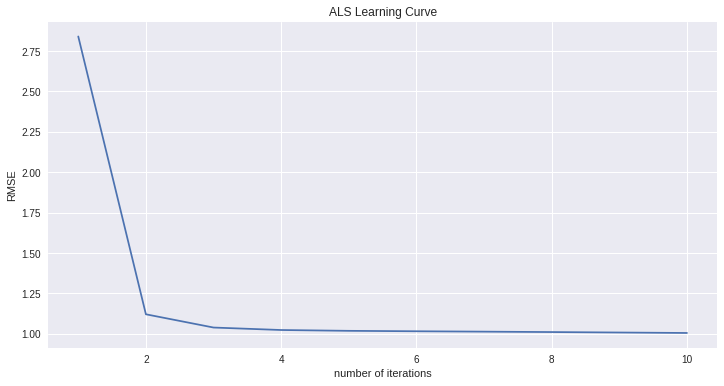

In [0]:
# create an array of num_iters
iter_array = list(range(1, 11))
# create learning curve plot
plot_learning_curve(iter_array, train, validation, 0.05, 20)

After 3 iterations, alternating gradient descend starts to converge at an error around 0.8

### Model testing
And finally, make a prediction and check the testing error using out-of-sample data

In [0]:
# make prediction using test data
test_data = test.map(lambda p: (p[0], p[1]))
predictions = final_model.predictAll(test_data).map(lambda r: ((r[0], r[1]), r[2]))
# get the rating result
ratesAndPreds = test.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
# get the RMSE
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
error = math.sqrt(MSE)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.9009


### Make movie recommendation to myself
We need to define a function that takes new user's movie rating and output top 10 recommendations

In [0]:
def get_movieId(df_movies, fav_movie_list):
    """
    return all movieId(s) of user's favorite movies
    
    Parameters
    ----------
    df_movies: spark Dataframe, movies data
    
    fav_movie_list: list, user's list of favorite movies
    
    Return
    ------
    movieId_list: list of movieId(s)
    """
    movieId_list = []
    for movie in fav_movie_list:
        movieIds = df_movies \
            .filter(movies.title.like('%{}%'.format(movie))) \
            .select('movieId') \
            .rdd \
            .map(lambda r: r[0]) \
            .collect()
        movieId_list.extend(movieIds)
    return list(set(movieId_list))


def add_new_user_to_data(train_data, movieId_list, spark_context):
    """
    add new rows with new user, user's movie and ratings to
    existing train data

    Parameters
    ----------
    train_data: spark RDD, ratings data
    
    movieId_list: list, list of movieId(s)

    spark_context: Spark Context object
    
    Return
    ------
    new train data with the new user's rows
    """
    # get new user id
    new_id = train_data.map(lambda r: r[0]).max() + 1
    # get max rating
    max_rating = train_data.map(lambda r: r[2]).max()
    # create new user rdd
    user_rows = [(new_id, movieId, max_rating) for movieId in movieId_list]
    new_rdd = spark_context.parallelize(user_rows)
    # return new train data
    return train_data.union(new_rdd)


def get_inference_data(train_data, df_movies, movieId_list):
    """
    return a rdd with the userid and all movies (except ones in movieId_list)

    Parameters
    ----------
    train_data: spark RDD, ratings data

    df_movies: spark Dataframe, movies data
    
    movieId_list: list, list of movieId(s)

    Return
    ------
    inference data: Spark RDD
    """
    # get new user id
    new_id = train_data.map(lambda r: r[0]).max() + 1
    # return inference rdd
    return df_movies.rdd \
        .map(lambda r: r[0]) \
        .distinct() \
        .filter(lambda x: x not in movieId_list) \
        .map(lambda x: (new_id, x))


def make_recommendation(best_model_params, ratings_data, df_movies, 
                        fav_movie_list, n_recommendations, spark_context):
    """
    return top n movie recommendation based on user's input list of favorite movies


    Parameters
    ----------
    best_model_params: dict, {'iterations': iter, 'rank': rank, 'lambda_': reg}

    ratings_data: spark RDD, ratings data

    df_movies: spark Dataframe, movies data

    fav_movie_list: list, user's list of favorite movies

    n_recommendations: int, top n recommendations

    spark_context: Spark Context object

    Return
    ------
    list of top n movie recommendations
    """
    # modify train data by adding new user's rows
    movieId_list = get_movieId(df_movies, fav_movie_list)
    train_data = add_new_user_to_data(ratings_data, movieId_list, spark_context)
    
    # train best ALS
    model = ALS.train(
        ratings=train_data,
        iterations=best_model_params.get('iterations', None),
        rank=best_model_params.get('rank', None),
        lambda_=best_model_params.get('lambda_', None),
        seed=99)
    
    # get inference rdd
    inference_rdd = get_inference_data(ratings_data, df_movies, movieId_list)
    
    # inference
    predictions = model.predictAll(inference_rdd).map(lambda r: (r[1], r[2]))
    
    # get top n movieId
    topn_rows = predictions.sortBy(lambda r: r[1], ascending=False).take(n_recommendations)
    topn_ids = [r[0] for r in topn_rows]
    
    # return movie titles
    return df_movies.filter(movies.movieId.isin(topn_ids)) \
                    .select('title') \
                    .rdd \
                    .map(lambda r: r[0]) \
                    .collect()

Let's pretend I am a new user in this recommender system. I will input a handful of my all-time favorite movies into the system. And then the system should output top N movie recommendations for me to watch

In [0]:
# my favorite movies
my_favorite_movies = ['Big Lebowski, The']

# get recommends
recommends = make_recommendation(
    best_model_params={'iterations': 10, 'rank': 20, 'lambda_': 0.05}, 
    ratings_data=rating_data, 
    df_movies=movies, 
    fav_movie_list=my_favorite_movies, 
    n_recommendations=10, 
    spark_context=sc)

print('Recommendations for {}:'.format(my_favorite_movies[0]))
for i, title in enumerate(recommends):
    print('{0}: {1}'.format(i+1, title))

Recommendations for Big Lebowski, The:
1: Godfather, The (1972)
2: Monty Python and the Holy Grail (1975)
3: Once Upon a Time in the West (C'era una volta il West) (1968)
4: Godfather: Part II, The (1974)
5: Yojimbo (1961)
6: Hustler, The (1961)
7: Rashomon (Rashômon) (1950)
8: Gallipoli (1981)
9: Sideways (2004)
10: Enter the Void (2009)


This list of movie recommendations look completely different than the list from my previous **KNN** model recommender. Not only it recommends movies outside of years between 2007 and 2009 periods, but also recommends movies that were less known. So this can offer users some elements of suprise so that users won't get bored by getting the same popular movies all the time.

So this list of recommendations can be blended into the previous list of recommendations from **KNN** model recommender